## Imports

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from mrmr import mrmr_classif
from scipy.stats import randint, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import (
    RFE,
    RFECV,
    SelectFromModel,
    SelectKBest,
    SelectPercentile,
    SequentialFeatureSelector,
    chi2,
    f_classif,
    mutual_info_classif,
)
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer

## Load data

In [90]:
# X = pd.read_csv("species_relative_abundance.csv", sep=";")
# X = pd.read_csv("genus_features.csv", sep=";")
X = pd.read_csv("genus_features_all.csv", sep=";")
y = pd.read_csv("../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Class"]
X = X.set_index("Sample", drop=True)
print(X.shape)
assert X.shape[0] == y.shape[0]

(212, 1128)


## Feature selection algorithms classes

In [91]:
class XGBoostFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.estimator = XGBClassifier(**kwargs)
        self.k = k
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def transform(self, X):
        if self.k is not None:
            feature_importances = self.estimator.feature_importances_
            top_k_indices = feature_importances.argsort()[-self.k:]
            return X.iloc[:, top_k_indices]
        else:
            return X
    
    def get_support(self, indices=False):
        if self.k is not None:
            feature_importances = self.estimator.feature_importances_
            top_k_indices = feature_importances.argsort()[-self.k:]
            if indices:
                return top_k_indices
            else:
                support = np.zeros_like(feature_importances, dtype=bool)
                support[top_k_indices] = True
                return support
        else:
            return np.ones(X.shape[1], dtype=bool)

class ANOVAFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.selector = SelectKBest(score_func=f_classif, k=k)
        self.k = k
    
    def fit(self, X, y):
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_support(self, indices=False):
        return self.selector.get_support(indices=indices)

class Chi2FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.selector = SelectKBest(score_func=chi2, k=k)
        self.k = k
    
    def fit(self, X, y):
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_support(self, indices=False):
        return self.selector.get_support(indices=indices)

class InformationGainFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.selector = SelectKBest(score_func=mutual_info_classif, k=k)
        self.k = k
    
    def fit(self, X, y):
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_support(self, indices=False):
        # print(self.selector.get_support(indices=True))
        return self.selector.get_support(indices=indices)

class MRMRFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=10, **kwargs):
        self.k = k
    
    def fit(self, X, y):
        self.selected_features = mrmr_classif(X=X, y=y, K=self.k, show_progress=False)
        return self
    
    def transform(self, X):
        return X[self.selected_features]

    def get_support(self, indices=False):
        return self.selected_features if indices else None

    def get_feature_names_out(self):
        return self.selected_features



## Main class

In [92]:
class FeatureSelectionRandomizedSearch:
    def __init__(
        self,
        classifiers: dict,
        param_distributions: dict,
        feature_selection_algorithms: dict = None,
        metrics: list = None,
        test_size: float = 0.2,
        use_smote: bool = False,
        num_features: int = None,
        n_cv: int = 5,
        n_iter: int = 10,
        scoring: str = None,
        use_log_scale = False,
    ):
        """
        A class for performing feature selection using randomized search and evaluating the results.

        Parameters:
            classifiers (dict): A dictionary of classifiers where the keys are classifier names and the values are classifier objects.
            param_distributions (dict): A dictionary of parameter distributions for each classifier where the keys are classifier names and the values are parameter distributions.
            feature_selection_algorithms (dict, optional): A dictionary of feature selection algorithms where the keys are algorithm names and the values are algorithm objects. Defaults to None.
            metrics (list, optional): A list of evaluation metrics. Defaults to None.
            test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
            use_smote (bool, optional): Whether to use SMOTE for oversampling the training data. Defaults to False.
            num_features (int, optional): The number of top features to select. Defaults to None.
            n_cv (int, optional): The number of cross-validation folds. Defaults to 5.
            n_iter (int, optional): The number of iterations for randomized search. Defaults to 10.
            scoring (str, optional): The scoring metric for randomized search. Defaults to None.
            use_log_scale (bool, optional): Whether to use Log transformation or not. Defaults to False.
        """
        self.classifiers = classifiers
        self.param_distributions = param_distributions
        self.feature_selection_algorithms = feature_selection_algorithms
        self.metrics = metrics
        self.results = {}
        self.test_size = test_size
        self.use_smote = use_smote
        self.num_features = num_features
        self.n_cv = n_cv
        self.n_iter = n_iter
        self.scoring = scoring
        self.use_log_scale = use_log_scale
    
    def build_pipeline(self, classifier, feature_selection_algorithm=None):
        """
        Build a pipeline for feature selection and classification.

        Parameters:
            classifier: The classifier object.
            feature_selection_algorithm: The feature selection algorithm object. Defaults to None.

        Returns:
            A Pipeline object.
        """
        steps = []
        if feature_selection_algorithm is not None:
            steps.append(('feature_selection', feature_selection_algorithm))

        if self.use_log_scale:
            steps.append(('log_transform', FunctionTransformer(np.log1p)))
            
        steps.append(('classification', classifier))
        return Pipeline(steps)
    
    def evaluate_metrics(self, pipeline, X, y):
        """
        Evaluate the specified metrics using cross-validation.

        Parameters:
            pipeline: The pipeline object.
            X: The input features.
            y: The target variable.

        Returns:
            A dictionary of metric scores.
        """
        metric_scores = {}
        for metric in self.metrics:
            scores = cross_val_score(pipeline, X, y, cv=self.n_cv, scoring=metric)
            metric_scores[metric] = scores
        return metric_scores
    
    def fit(self, X, y):
        """
        Fit the feature selection models and evaluate the results.

        Parameters:
            X: The input features.
            y: The target variable.
        """
        self.results = {}

        for fs_name, fs_algorithm in (fs_pbar := tqdm(self.feature_selection_algorithms.items(), position=0)):
            fs_pbar.set_description(f'Running features selection using {fs_name}')
            fs_results = {}    
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, stratify=y, random_state=42)
            
            for clf_name, clf in (clf_pbar := tqdm(self.classifiers.items(), position=1, leave=False)):
                clf_pbar.set_description(f'Running classifier {clf_name}')

                if fs_algorithm is not None:
                    fs_algorithm.fit(X_train, y_train)
            
                pipeline = self.build_pipeline(clf, fs_algorithm)

                random_search = RandomizedSearchCV(pipeline, param_distributions=self.param_distributions[clf_name], n_iter=self.n_iter, cv=self.n_cv, random_state=42, n_jobs=-1, scoring=self.scoring)
                
                if self.use_smote:
                    smote = SMOTE()
                    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                    random_search.fit(X_train_res, y_train_res)
                else:
                    random_search.fit(X_train, y_train)
                
                best_estimator = random_search.best_estimator_
                
                metric_scores = self.evaluate_metrics(best_estimator, X_test, y_test)
                
                fs_results[clf_name] = {
                    'best_score': random_search.best_score_,
                    'best_estimator': best_estimator,
                    'metric_scores': metric_scores,
                    'selected_features': X.columns[fs_algorithm.get_support(indices=False)].to_list() if fs_algorithm else X.columns 
                }

            self.results[fs_name] = fs_results
    
    # TODO FIX.
    def get_best_params(self, classifier_name: str, feature_selection_name: str):
        """
        Get the best parameters for a specific classifier and feature selection algorithm.

        Parameters:
            classifier_name: The name of the classifier.
            feature_selection_name: The name of the feature selection algorithm.

        Returns:
            The best parameters as a dictionary.
        """
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('best_params')
    # TODO FIX.
    def get_best_score(self, classifier_name: str, feature_selection_name: str):
        """
        Get the best score for a specific classifier and feature selection algorithm.

        Parameters:
            classifier_name: The name of the classifier.
            feature_selection_name: The name of the feature selection algorithm.

        Returns:
            The best score as a float.
        """
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('best_score')
    # TODO FIX.
    def get_metric_scores(self, classifier_name: str, feature_selection_name: str):
        """
        Get the metric scores for a specific classifier and feature selection algorithm.

        Parameters:
            classifier_name: The name of the classifier.
            feature_selection_name: The name of the feature selection algorithm.

        Returns:
            A dictionary of metric scores.
        """
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('metric_scores')
    # TODO FIX.
    def get_selected_features(self, classifier_name: str, feature_selection_name: str):
        """
        Get the selected features for a specific classifier and feature selection algorithm.

        Parameters:
            classifier_name: The name of the classifier.
            feature_selection_name: The name of the feature selection algorithm.

        Returns:
            The selected features as a list or DataFrame.
        """
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('selected_features')
    
    def plot_results(self, plot_output_path: str = 'output.png'):
        """
        Plot the results of feature selection and classification.

        Parameters:
            plot_output_path: The path to save the plot. Defaults to 'output.png'.
        """
        df = pd.DataFrame(columns=['Model', 'Metric', 'Score', 'Features'])

        for fs_name, fs_results in self.results.items():
            for clf_name, clf_result in fs_results.items():
                best_estimator = clf_result['best_estimator']
                metric_scores = clf_result['metric_scores']
                selected_features = clf_result['selected_features']

                for metric, scores in metric_scores.items():
                    for score in scores:
                        df = pd.concat([
                            df,
                            pd.DataFrame([{
                                'Model': clf_name,
                                'Metric': metric,
                                'Score': score,
                                'Features': f"{fs_name} (Top {self.num_features} features)" if self.feature_selection_algorithms[fs_name] else fs_name
                            }])],
                            ignore_index=True)

        g = sns.catplot(
            data=df,
            x='Model',
            y='Score',
            hue='Metric',
            col='Features',
            estimator=np.mean,
            kind='bar',
            errorbar='sd',
            capsize=0.1,
            errwidth=1,
            col_wrap=3,
            legend=False,
            sharex=False,
            sharey=False,
            legend_out=True
        )
        g.set(ylim=(0, 1.01))
        g.fig.subplots_adjust(top=1)
        g.fig.suptitle(f'Feature selection methods evaluation using {self.n_cv}-fold cross-validation')
        g.fig.tight_layout()
        g.tick_params(labelbottom=True)
        for ax in g.axes.ravel():
            ax.legend()

        plt.savefig(plot_output_path)

        plt.show()


## Running

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

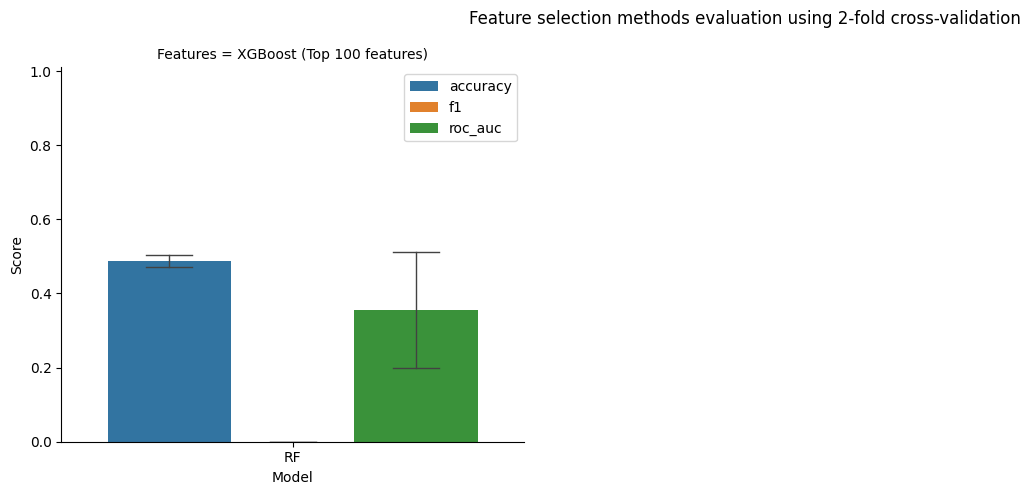

In [100]:
# define number of features to select
n_features_to_select = 100

# Define the classifiers
classifiers = {
    'RF': RandomForestClassifier(warm_start=True, n_jobs=-1, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(n_jobs=-1, random_state=42),
    'LR': LogisticRegression(warm_start=True, n_jobs=-1, random_state=42),
    'SVM': SVC(random_state=42),
}

# Define the feature selection algorithms
feature_selection_algorithms = {
    # 'RFE Logistic Regression': RFE(estimator=LogisticRegression(), n_features_to_select=n_features_to_select),
    # 'Sequential Feature Selector XGBoost': SequentialFeatureSelector(estimator=XGBClassifier(n_jobs=-1), n_features_to_select=n_features_to_select, n_jobs=-1),
    # "RFE SVM": RFEFeatureSelection(base_estimator=SVC(kernel="linear", C=1)),
    'Chi-square': SelectKBest(score_func=chi2, k=n_features_to_select),
    'ANOVA': SelectKBest(score_func=f_classif, k=n_features_to_select),
    'Information Gain': SelectKBest(score_func=mutual_info_classif, k=n_features_to_select),
    'XGBoost': SelectFromModel(estimator=XGBClassifier(n_jobs=-1), max_features=n_features_to_select, threshold=-np.inf),
    'MRMR': MRMRFeatureSelection(n_jobs=-1, random_state=42),
    'LASSO': SelectFromModel(estimator=Lasso(alpha=1), max_features=n_features_to_select, threshold=-np.inf),
    'All Features': None,
}

# Define the parameter distributions for each classifier
param_distributions = {
    "RF": {
        "classification__n_estimators": randint(1, 250),
        "classification__criterion": ["gini", "entropy"],
        "classification__max_depth": [None] + list(range(1, 20)),
        "classification__min_samples_split": randint(2, 20),
        "classification__max_features": ["sqrt", "log2"],
        "classification__min_samples_leaf": randint(1, 10),
        "classification__bootstrap": [True, False],
    },
    "AdaBoost": {
        "classification__n_estimators": randint(1, 250),
        "classification__learning_rate": uniform(0.01, 1.0),
        "classification__estimator": [RandomForestClassifier()],
        "classification__algorithm": ["SAMME", "SAMME.R"],
        "classification__random_state": [None, 42],
    },
    "XGBoost": {
        "classification__n_estimators": randint(1, 250),
        "classification__learning_rate": uniform(0.01, 1.0),
        "classification__max_depth": randint(1, 10),
        "classification__subsample": uniform(0.6, 0.4),
        "classification__colsample_bytree": uniform(0.6, 0.4),
        "classification__reg_alpha": uniform(0, 1),
        "classification__reg_lambda": uniform(0, 1),
    },
    "LR": { # Logistic regression
        "classification__C": uniform(0.1, 1.0),
        "classification__penalty": ["elasticnet", "l1", "l2"],
        "classification__class_weight": [None, "balanced"],
        "classification__max_iter": [100000],
    },
    "SVM": {
        "classification__C": uniform(0.1, 1.0),
        "classification__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "classification__degree": randint(1, 3),
        "classification__gamma": ["scale", "auto"],
        "classification__class_weight": [None, "balanced"],
        "classification__probability": [True, False],
    },
}

# Instantiate the FeatureSelectionRandomizedSearch class
feature_selection_search = FeatureSelectionRandomizedSearch(
    classifiers,
    param_distributions,
    feature_selection_algorithms,
    metrics=["accuracy", "f1", "roc_auc"],
    test_size=0.2,
    use_smote=False,
    use_log_scale=False,
    num_features=n_features_to_select,
    n_cv=2,
    n_iter=2,
    scoring='f1',
)

# Fit the search using your data
feature_selection_search.fit(X, y)

# Plot the results
feature_selection_search.plot_results(plot_output_path='fs_100_species.png')

In [123]:
import pickle
from datetime import datetime

with open(f'feature_selection_search_results_{datetime.now().strftime("%d.%m.%Y_%H.%M.%S")}.p', 'wb') as fp:
    pickle.dump(feature_selection_search.results, fp, protocol=pickle.HIGHEST_PROTOCOL)
# pickle.dump(feature_selection_search.results, 'feature_selection_search_results')

In [103]:
selected_features = {}

for fsname in feature_selection_algorithms.keys():
  if fsname != 'All Features':
    selected_features[fsname] = feature_selection_search.results[fsname]['RF']['selected_features']

                                                   id
ANOVA Information Gain XGBoost LASSO                 
True  False            True    False          Proteus
                       False   False       Salmonella
      True             False   False         HGM20899
      False            False   True     Haemophilus_D
      True             True    False      Haemophilus
...                                               ...
False False            False   True           UBA1829
                               True   Campylobacter_A
                               True           CAG-411
                               True     Clostridium_A
                               True            VUNA01

[331 rows x 1 columns]


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

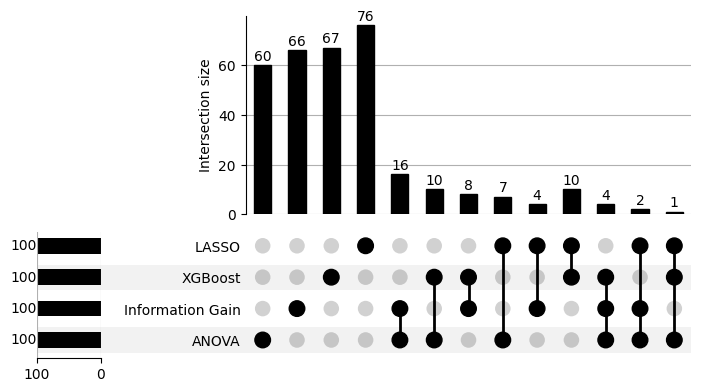

In [96]:
import upsetplot

data = upsetplot.from_contents(selected_features)
print(data)
upsetplot.plot(data=data,show_counts=True)

In [97]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]